In [1]:
#standard library load

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import gc

#https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [2]:
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

In [3]:
import xgboost as xgb

from xgboost.sklearn import XGBClassifier

from sklearn.grid_search import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold


/home/gilles/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/gilles/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## v3.0 from V2.0

## process Data from previous application

## refresh of data transformation

## use of distribution plotting to see relevance of features

## remove the day/hours application

## added coverage by income

## perform a K-Fold cross validation

## ---------------------------------------------------------------------------------------------------

## Define utility to observe the data and its distribution according to difficulty in payment

In [4]:
# Plots the distribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## ---------------------------------------------------------------------------------------------------

# Load the data

In [6]:
# Load training data
df = pd.read_csv("Data/application_train.csv")

In [7]:
#load file linking credit contracts to customer account
df_bureau = pd.read_csv("Data/bureau.csv")

In [8]:
df_install = pd.read_csv("Data/installments_payments.csv")

In [9]:
df_cash = pd.read_csv("Data/POS_CASH_balance.csv")

In [10]:
df_credit_card = pd.read_csv("Data/credit_card_balance.csv")

In [11]:
df_previous = pd.read_csv("Data/previous_application.csv")

## load the test data

In [12]:
df2 = pd.read_csv("Data/application_test.csv")

In [13]:
print(df.shape,df2.shape)

(307511, 122) (48744, 121)


## process the data for bureau

In [14]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [15]:
# for simplicity reason, remove other currencies from the dataframe
df_bureau = df_bureau[df_bureau["CREDIT_CURRENCY"]=="currency 1"]
df_bureau = df_bureau.drop("CREDIT_CURRENCY", 1)

#drop also a title field
df_bureau = df_bureau.drop("SK_ID_BUREAU", 1)

#if "  " in list(df):
#    df2 = df2.drop("  ", axis=1) 

In [16]:
#transform categories into values
categories= ["CREDIT_ACTIVE","CREDIT_TYPE"]

for i in categories:
    dummy = pd.get_dummies(df_bureau[i],prefix_sep='_', prefix=i)
    df_bureau = pd.concat([df_bureau,dummy],axis=1)
    df_bureau = df_bureau.drop(i, 1)

if (dummy is not None): 
    del dummy
    gc.collect()

In [17]:
df_bureau.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan',
       'CRE

In [18]:
# Group by the client id, calculate aggregation statistics
bureau_agg = df_bureau.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()


SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

               ... CREDIT_TYPE_Real estate loan                   \
  mean max min ...                        count mean max min sum   
0  0.0   0   0 ...                            7  0.0   0   0   0   
1  0.0   0   0 ...                            8  0.0   0   0   0   
2  0.0   0   0 ...                            4  0.0   0   0   0   
3  0.0   0   0 ...                            2  0.0   0   0   0   
4  0.0   0   0 ...                            3  0.0   0   0   0   

  CREDIT_TYPE_Unknown type of loan                   
                             count mean max min sum  
0                                7  0.0   0   0   0  
1                                8  0.0   0   0   0  
2                                4  0.0   0   0   0  
3                                2  0.0   0   0   0  
4                                3  0.0   0   0   0  

[5 rows x 156 columns]

In [19]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [20]:
#columns

In [21]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_max,bureau_CREDIT_TYPE_Real estate loan_min,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_max,bureau_CREDIT_TYPE_Unknown type of loan_min,bureau_CREDIT_TYPE_Unknown type of loan_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,0.0,0,0,0,7,0.0,0,0,0
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,0.0,0,0,0,8,0.0,0,0,0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,0.0,0,0,0,4,0.0,0,0,0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,0.0,0,0,0,2,0.0,0,0,0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,0.0,0,0,0,3,0.0,0,0,0


In [22]:
# Merge with the training data
df = df.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_max,bureau_CREDIT_TYPE_Real estate loan_min,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_max,bureau_CREDIT_TYPE_Unknown type of loan_min,bureau_CREDIT_TYPE_Unknown type of loan_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
# Merge with the test data
df2 = df2.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')


In [24]:
del [bureau_agg,df_bureau]
gc.collect()

276

In [25]:
print(df.shape,df2.shape)

(307511, 277) (48744, 276)


## process the data for installments

In [26]:
df_install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [27]:
#create new features
df_install["AMT_DIFFERENCE"] = df_install["AMT_INSTALMENT"] - df_install["AMT_PAYMENT"]
df_install["DAYS_DIFFERENCE"] = df_install["DAYS_INSTALMENT"] - df_install["DAYS_ENTRY_PAYMENT"]

In [28]:
#remove SK_ID_PREV
df_install = df_install.drop("SK_ID_PREV", 1)

In [29]:
# Group by the client id, calculate aggregation statistics
install_agg = df_install.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
install_agg.head()

SK_ID_CURR NUM_INSTALMENT_VERSION                            \
                              count      mean  max  min   sum   
0     100001                      7  1.142857  2.0  1.0   8.0   
1     100002                     19  1.052632  2.0  1.0  20.0   
2     100003                     25  1.040000  2.0  1.0  26.0   
3     100004                      3  1.333333  2.0  1.0   4.0   
4     100005                      9  1.111111  2.0  1.0  10.0   

  NUM_INSTALMENT_NUMBER                     ...   AMT_DIFFERENCE            \
                  count       mean max min  ...            count mean  max   
0                     7   2.714286   4   1  ...                7  0.0  0.0   
1                    19  10.000000  19   1  ...               19  0.0  0.0   
2                    25   5.080000  12   1  ...               25  0.0  0.0   
3                     3   2.000000   3   1  ...                3  0.0  0.0   
4                     9   5.000000   9   1  ...                9  0.0  0.0   

            DAYS_DIFFERENCE                                
   min  sum           count       mean   max   min    sum  
0  0.0  0.0               7   7.285714  36.0 -11.0   51.0  
1  0.0  0.0              19  20.421053  31.0  12.0  388.0  
2  0.0  0.0              25   7.160000  14.0   1.0  179.0  
3  0.0  0.0               3   7.666667  11.0   3.0   23.0  
4  0.0  0.0               9  23.555556  37.0  -1.0  212.0  

[5 rows x 41 columns]

In [30]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in install_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in install_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('install_%s_%s' % (var, stat))

In [31]:
# Assign the list of columns names as the dataframe column names
install_agg.columns = columns
install_agg.head()

,SK_ID_CURR,install_NUM_INSTALMENT_VERSION_count,install_NUM_INSTALMENT_VERSION_mean,install_NUM_INSTALMENT_VERSION_max,install_NUM_INSTALMENT_VERSION_min,install_NUM_INSTALMENT_VERSION_sum,install_NUM_INSTALMENT_NUMBER_count,install_NUM_INSTALMENT_NUMBER_mean,install_NUM_INSTALMENT_NUMBER_max,install_NUM_INSTALMENT_NUMBER_min,...,install_AMT_DIFFERENCE_count,install_AMT_DIFFERENCE_mean,install_AMT_DIFFERENCE_max,install_AMT_DIFFERENCE_min,install_AMT_DIFFERENCE_sum,install_DAYS_DIFFERENCE_count,install_DAYS_DIFFERENCE_mean,install_DAYS_DIFFERENCE_max,install_DAYS_DIFFERENCE_min,install_DAYS_DIFFERENCE_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,0.0,0.0,0.0,0.0,7,7.285714,36.0,-11.0,51.0
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,0.0,0.0,0.0,0.0,19,20.421053,31.0,12.0,388.0
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,0.0,0.0,0.0,0.0,25,7.160000,14.0,1.0,179.0
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,0.0,0.0,0.0,0.0,3,7.666667,11.0,3.0,23.0
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,0.0,0.0,0.0,0.0,9,23.555556,37.0,-1.0,212.0


In [32]:
# Merge with the training data
df = df.merge(install_agg, on = 'SK_ID_CURR', how = 'left')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,install_AMT_DIFFERENCE_count,install_AMT_DIFFERENCE_mean,install_AMT_DIFFERENCE_max,install_AMT_DIFFERENCE_min,install_AMT_DIFFERENCE_sum,install_DAYS_DIFFERENCE_count,install_DAYS_DIFFERENCE_mean,install_DAYS_DIFFERENCE_max,install_DAYS_DIFFERENCE_min,install_DAYS_DIFFERENCE_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,19.0,0.000000,0.000,0.0,0.000,19.0,20.421053,31.0,12.0,388.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,25.0,0.000000,0.000,0.0,0.000,25.0,7.160000,14.0,1.0,179.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,3.0,0.000000,0.000,0.0,0.000,3.0,7.666667,11.0,3.0,23.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,16.0,0.000000,0.000,0.0,0.000,16.0,19.375000,77.0,1.0,310.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,66.0,452.384318,22655.655,0.0,29857.365,66.0,3.636364,31.0,-12.0,240.0


In [33]:
# Merge with the test data
df2 = df2.merge(install_agg, on = 'SK_ID_CURR', how = 'left')

In [34]:
del [install_agg,df_install]
gc.collect()

402

In [35]:
print(df.shape,df2.shape)

(307511, 317) (48744, 316)


## process the data for cash balance

In [36]:
df_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [37]:
df_cash["NAME_CONTRACT_STATUS"].unique()

array(['Active', 'Completed', 'Signed', 'Approved',
       'Returned to the store', 'Demand', 'Canceled', 'XNA',
       'Amortized debt'], dtype=object)

In [38]:
#remove SK_ID_PREV,NAME_CONTRACT_STATUS
df_cash = df_cash.drop(["SK_ID_PREV","NAME_CONTRACT_STATUS"], 1)

In [39]:
# Group by the client id, calculate aggregation statistics
cash_agg = df_cash.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
cash_agg.head()

SK_ID_CURR MONTHS_BALANCE                          CNT_INSTALMENT  \
                      count       mean max min   sum          count   
0     100001              9 -72.555556 -53 -96  -653              9   
1     100002             19 -10.000000  -1 -19  -190             19   
2     100003             28 -43.785714 -18 -77 -1226             28   
3     100004              4 -25.500000 -24 -27  -102              4   
4     100005             11 -20.000000 -15 -25  -220             10   

                         ... SK_DPD                       SK_DPD_DEF  \
        mean   max   min ...  count      mean max min sum      count   
0   4.000000   4.0   4.0 ...      9  0.777778   7   0   7          9   
1  24.000000  24.0  24.0 ...     19  0.000000   0   0   0         19   
2  10.107143  12.0   6.0 ...     28  0.000000   0   0   0         28   
3   3.750000   4.0   3.0 ...      4  0.000000   0   0   0          4   
4  11.700000  12.0   9.0 ...     11  0.000000   0   0   0         11   

                         
       mean max min sum  
0  0.777778   7   0   7  
1  0.000000   0   0   0  
2  0.000000   0   0   0  
3  0.000000   0   0   0  
4  0.000000   0   0   0  

[5 rows x 26 columns]

In [40]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in cash_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in cash_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('cash_pos_%s_%s' % (var, stat))

In [41]:
# Assign the list of columns names as the dataframe column names
cash_agg.columns = columns
cash_agg.head()

,SK_ID_CURR,cash_pos_MONTHS_BALANCE_count,cash_pos_MONTHS_BALANCE_mean,cash_pos_MONTHS_BALANCE_max,cash_pos_MONTHS_BALANCE_min,cash_pos_MONTHS_BALANCE_sum,cash_pos_CNT_INSTALMENT_count,cash_pos_CNT_INSTALMENT_mean,cash_pos_CNT_INSTALMENT_max,cash_pos_CNT_INSTALMENT_min,...,cash_pos_SK_DPD_count,cash_pos_SK_DPD_mean,cash_pos_SK_DPD_max,cash_pos_SK_DPD_min,cash_pos_SK_DPD_sum,cash_pos_SK_DPD_DEF_count,cash_pos_SK_DPD_DEF_mean,cash_pos_SK_DPD_DEF_max,cash_pos_SK_DPD_DEF_min,cash_pos_SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,9,0.777778,7,0,7,9,0.777778,7,0,7
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,19,0.000000,0,0,0,19,0.000000,0,0,0
2,100003,28,-43.785714,-18,-77,-1226,28,10.107143,12.0,6.0,...,28,0.000000,0,0,0,28,0.000000,0,0,0
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,4,0.000000,0,0,0,4,0.000000,0,0,0
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,11,0.000000,0,0,0,11,0.000000,0,0,0


In [42]:
# Merge with the training data
df = df.merge(cash_agg, on = 'SK_ID_CURR', how = 'left')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cash_pos_SK_DPD_count,cash_pos_SK_DPD_mean,cash_pos_SK_DPD_max,cash_pos_SK_DPD_min,cash_pos_SK_DPD_sum,cash_pos_SK_DPD_DEF_count,cash_pos_SK_DPD_DEF_mean,cash_pos_SK_DPD_DEF_max,cash_pos_SK_DPD_DEF_min,cash_pos_SK_DPD_DEF_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,19.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,28.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,21.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,66.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0


In [43]:
# Merge with the test data
df2 = df2.merge(cash_agg, on = 'SK_ID_CURR', how = 'left')

In [44]:
del [cash_agg,df_cash]
gc.collect()

524

In [45]:
print(df.shape,df2.shape)

(307511, 342) (48744, 341)


## process the data for credit card

In [46]:
df_credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [47]:
#transform categories into values
categories= ["NAME_CONTRACT_STATUS"]

for i in categories:
    dummy = pd.get_dummies(df_credit_card[i],prefix_sep='_', prefix=i)
    df_credit_card = pd.concat([df_credit_card,dummy],axis=1)
    df_credit_card = df_credit_card.drop(i, 1)

if (dummy is not None): 
    del dummy
    gc.collect()


In [48]:
#remove SK_ID_PREV
df_credit_card = df_credit_card.drop("SK_ID_PREV", 1)

In [49]:
df_credit_card.columns

Index(['SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF',
       'NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Approved',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal',
       'NAME_CONTRACT_STATUS_Signed'],
      dtype='object')

In [50]:
# Group by the client id, calculate aggregation statistics
credit_card_agg = df_credit_card.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
credit_card_agg.head()


SK_ID_CURR MONTHS_BALANCE                     AMT_BALANCE                \
                      count  mean max min   sum       count          mean   
0     100006              6  -3.5  -1  -6   -21           6      0.000000   
1     100011             74 -38.5  -2 -75 -2849          74  54482.111149   
2     100013             96 -48.5  -1 -96 -4656          96  18159.919219   
3     100021             17 -10.0  -2 -18  -170          17      0.000000   
4     100023              8  -7.5  -4 -11   -60           8      0.000000   

                  ... NAME_CONTRACT_STATUS_Sent proposal                   \
         max  min ...                              count mean max min sum   
0       0.00  0.0 ...                                  6  0.0   0   0   0   
1  189000.00  0.0 ...                                 74  0.0   0   0   0   
2  161420.22  0.0 ...                                 96  0.0   0   0   0   
3       0.00  0.0 ...                                 17  0.0   0   0   0   
4       0.00  0.0 ...                                  8  0.0   0   0   0   

  NAME_CONTRACT_STATUS_Signed                   
                        count mean max min sum  
0                           6  0.0   0   0   0  
1                          74  0.0   0   0   0  
2                          96  0.0   0   0   0  
3                          17  0.0   0   0   0  
4                           8  0.0   0   0   0  

[5 rows x 136 columns]

In [51]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in credit_card_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in credit_card_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('credit_card_%s_%s' % (var, stat))

In [52]:
# Assign the list of columns names as the dataframe column names
credit_card_agg.columns = columns
credit_card_agg.head()

,SK_ID_CURR,credit_card_MONTHS_BALANCE_count,credit_card_MONTHS_BALANCE_mean,credit_card_MONTHS_BALANCE_max,credit_card_MONTHS_BALANCE_min,credit_card_MONTHS_BALANCE_sum,credit_card_AMT_BALANCE_count,credit_card_AMT_BALANCE_mean,credit_card_AMT_BALANCE_max,credit_card_AMT_BALANCE_min,...,credit_card_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_NAME_CONTRACT_STATUS_Sent proposal_mean,credit_card_NAME_CONTRACT_STATUS_Sent proposal_max,credit_card_NAME_CONTRACT_STATUS_Sent proposal_min,credit_card_NAME_CONTRACT_STATUS_Sent proposal_sum,credit_card_NAME_CONTRACT_STATUS_Signed_count,credit_card_NAME_CONTRACT_STATUS_Signed_mean,credit_card_NAME_CONTRACT_STATUS_Signed_max,credit_card_NAME_CONTRACT_STATUS_Signed_min,credit_card_NAME_CONTRACT_STATUS_Signed_sum
0,100006,6,-3.5,-1,-6,-21,6,0.000000,0.00,0.0,...,6,0.0,0,0,0,6,0.0,0,0,0
1,100011,74,-38.5,-2,-75,-2849,74,54482.111149,189000.00,0.0,...,74,0.0,0,0,0,74,0.0,0,0,0
2,100013,96,-48.5,-1,-96,-4656,96,18159.919219,161420.22,0.0,...,96,0.0,0,0,0,96,0.0,0,0,0
3,100021,17,-10.0,-2,-18,-170,17,0.000000,0.00,0.0,...,17,0.0,0,0,0,17,0.0,0,0,0
4,100023,8,-7.5,-4,-11,-60,8,0.000000,0.00,0.0,...,8,0.0,0,0,0,8,0.0,0,0,0


In [53]:
# Merge with the training data
df = df.merge(credit_card_agg, on = 'SK_ID_CURR', how = 'left')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,credit_card_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_NAME_CONTRACT_STATUS_Sent proposal_mean,credit_card_NAME_CONTRACT_STATUS_Sent proposal_max,credit_card_NAME_CONTRACT_STATUS_Sent proposal_min,credit_card_NAME_CONTRACT_STATUS_Sent proposal_sum,credit_card_NAME_CONTRACT_STATUS_Signed_count,credit_card_NAME_CONTRACT_STATUS_Signed_mean,credit_card_NAME_CONTRACT_STATUS_Signed_max,credit_card_NAME_CONTRACT_STATUS_Signed_min,credit_card_NAME_CONTRACT_STATUS_Signed_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Merge with the test data
df2 = df2.merge(credit_card_agg, on = 'SK_ID_CURR', how = 'left')

In [55]:
del [df_credit_card,credit_card_agg]
gc.collect()

700

In [56]:
print(df.shape,df2.shape)

(307511, 477) (48744, 476)


## Process the data for previous application

In [57]:
df_previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
len(df_previous)

1670214

In [59]:
100*df_previous.isnull().sum()/len(df_previous)

SK_ID_PREV                      0.000000
SK_ID_CURR                      0.000000
NAME_CONTRACT_TYPE              0.000000
AMT_ANNUITY                    22.286665
AMT_APPLICATION                 0.000000
AMT_CREDIT                      0.000060
AMT_DOWN_PAYMENT               53.636480
AMT_GOODS_PRICE                23.081773
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
FLAG_LAST_APPL_PER_CONTRACT     0.000000
NFLAG_LAST_APPL_IN_DAY          0.000000
RATE_DOWN_PAYMENT              53.636480
RATE_INTEREST_PRIMARY          99.643698
RATE_INTEREST_PRIVILEGED       99.643698
NAME_CASH_LOAN_PURPOSE          0.000000
NAME_CONTRACT_STATUS            0.000000
DAYS_DECISION                   0.000000
NAME_PAYMENT_TYPE               0.000000
CODE_REJECT_REASON              0.000000
NAME_TYPE_SUITE                49.119754
NAME_CLIENT_TYPE                0.000000
NAME_GOODS_CATEGORY             0.000000
NAME_PORTFOLIO                  0.000000
NAME_PRODUCT_TYP

In [60]:
#remove RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEGED columns
df_previous.drop('RATE_INTEREST_PRIMARY', axis=1, inplace=True)
df_previous.drop('RATE_INTEREST_PRIVILEGED', axis=1, inplace=True)

In [62]:
#remove some more that "don't look" relevant
df_previous.drop('DAYS_FIRST_DRAWING', axis=1, inplace=True)
df_previous.drop('WEEKDAY_APPR_PROCESS_START', axis=1, inplace=True)
df_previous.drop('HOUR_APPR_PROCESS_START', axis=1, inplace=True)
df_previous.drop('SELLERPLACE_AREA', axis=1, inplace=True)

ValueError: labels ['DAYS_FIRST_DRAWING'] not contained in axis

In [63]:
len(df_previous["SK_ID_CURR"].unique())

338857

In [66]:
previous_SKID = df_previous["SK_ID_CURR"].unique()
current_SKID = df["SK_ID_CURR"].unique()

In [67]:
counter = 0

for i in previous_SKID:
    if i in current_SKID :
        counter = counter + 1
print("counter 1 =",counter )    

counter = 291057


In [ ]:
current_SKID = df2["SK_ID_CURR"].unique()

In [68]:
counter = 0

for i in previous_SKID:
    if i in current_SKID :
        counter = counter + 1
print("counter 2 =",counter )  

counter 2 = 291057


In [69]:
len(previous_SKID)

338857

In [62]:
#remove SK_ID_PREV
df_previous.drop('SK_ID_PREV', axis=1, inplace=True)

In [63]:
print(df_previous.shape)

(1670214, 33)


In [70]:
100*df_previous.isnull().sum()/len(df_previous)

SK_ID_PREV                      0.000000
SK_ID_CURR                      0.000000
NAME_CONTRACT_TYPE              0.000000
AMT_ANNUITY                    22.286665
AMT_APPLICATION                 0.000000
AMT_CREDIT                      0.000060
AMT_DOWN_PAYMENT               53.636480
AMT_GOODS_PRICE                23.081773
FLAG_LAST_APPL_PER_CONTRACT     0.000000
NFLAG_LAST_APPL_IN_DAY          0.000000
RATE_DOWN_PAYMENT              53.636480
NAME_CASH_LOAN_PURPOSE          0.000000
NAME_CONTRACT_STATUS            0.000000
DAYS_DECISION                   0.000000
NAME_PAYMENT_TYPE               0.000000
CODE_REJECT_REASON              0.000000
NAME_TYPE_SUITE                49.119754
NAME_CLIENT_TYPE                0.000000
NAME_GOODS_CATEGORY             0.000000
NAME_PORTFOLIO                  0.000000
NAME_PRODUCT_TYPE               0.000000
CHANNEL_TYPE                    0.000000
NAME_SELLER_INDUSTRY            0.000000
CNT_PAYMENT                    22.286366
NAME_YIELD_GROUP

In [72]:
previous_categories = ['NAME_CONTRACT_TYPE',   
       'FLAG_LAST_APPL_PER_CONTRACT', 
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 
       'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'NFLAG_INSURED_ON_APPROVAL']

In [73]:
for i in previous_categories:
    dummy = pd.get_dummies(df_previous[i],prefix_sep='_', prefix=i)
    df_previous = pd.concat([df_previous,dummy],axis=1)
    df_previous = df_previous.drop(i, 1)

In [74]:
print(df_previous.shape)

(1670214, 153)


In [75]:
# Group by the client id, calculate aggregation statistics
previous_agg = df_previous.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()


In [76]:
previous_agg.head()

SK_ID_CURR SK_ID_PREV                                     AMT_ANNUITY  \
                  count     mean      max      min      sum       count   
0     100001          1  1369693  1369693  1369693  1369693           1   
1     100002          1  1038818  1038818  1038818  1038818           1   
2     100003          3  2281150  2636178  1810518  6843451           3   
3     100004          1  1564014  1564014  1564014  1564014           1   
4     100005          2  2176837  2495675  1857999  4353674           1   

                                  ... NFLAG_INSURED_ON_APPROVAL_0.0            \
        mean        max       min ...                         count      mean   
0   3951.000   3951.000  3951.000 ...                             1  1.000000   
1   9251.775   9251.775  9251.775 ...                             1  1.000000   
2  56553.990  98356.995  6737.310 ...                             3  0.333333   
3   5357.250   5357.250  5357.250 ...                             1  1.000000   
4   4813.200   4813.200  4813.200 ...                             2  0.500000   

              NFLAG_INSURED_ON_APPROVAL_1.0                        
  max min sum                         count      mean max min sum  
0   1   1   1                             1  0.000000   0   0   0  
1   1   1   1                             1  0.000000   0   0   0  
2   1   0   1                             3  0.666667   1   0   2  
3   1   1   1                             1  0.000000   0   0   0  
4   1   0   1                             2  0.000000   0   0   0  

[5 rows x 761 columns]

In [77]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in previous_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in previous_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('credit_card_%s_%s' % (var, stat))

In [78]:
# Assign the list of columns names as the dataframe column names
previous_agg.columns = columns
previous_agg.head()

,SK_ID_CURR,credit_card_SK_ID_PREV_count,credit_card_SK_ID_PREV_mean,credit_card_SK_ID_PREV_max,credit_card_SK_ID_PREV_min,credit_card_SK_ID_PREV_sum,credit_card_AMT_ANNUITY_count,credit_card_AMT_ANNUITY_mean,credit_card_AMT_ANNUITY_max,credit_card_AMT_ANNUITY_min,...,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_count,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_mean,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_max,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_min,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_sum,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_count,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_mean,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_max,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_min,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_sum
0,100001,1,1369693,1369693,1369693,1369693,1,3951.000,3951.000,3951.000,...,1,1.000000,1,1,1,1,0.000000,0,0,0
1,100002,1,1038818,1038818,1038818,1038818,1,9251.775,9251.775,9251.775,...,1,1.000000,1,1,1,1,0.000000,0,0,0
2,100003,3,2281150,2636178,1810518,6843451,3,56553.990,98356.995,6737.310,...,3,0.333333,1,0,1,3,0.666667,1,0,2
3,100004,1,1564014,1564014,1564014,1564014,1,5357.250,5357.250,5357.250,...,1,1.000000,1,1,1,1,0.000000,0,0,0
4,100005,2,2176837,2495675,1857999,4353674,1,4813.200,4813.200,4813.200,...,2,0.500000,1,0,1,2,0.000000,0,0,0


In [79]:
# Merge with the training data
df = df.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_count,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_mean,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_max,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_min,credit_card_NFLAG_INSURED_ON_APPROVAL_0.0_sum,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_count,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_mean,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_max,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_min,credit_card_NFLAG_INSURED_ON_APPROVAL_1.0_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,1.000000,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,3.0,0.333333,1.0,0.0,1.0,3.0,0.666667,1.0,0.0,2.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1.0,1.000000,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,9.0,0.444444,1.0,0.0,4.0,9.0,0.000000,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,6.0,0.333333,1.0,0.0,2.0,6.0,0.500000,1.0,0.0,3.0


In [80]:
# Merge with the test data
df2 = df2.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

In [81]:
del [df_previous,previous_agg]
gc.collect()

1630

In [82]:
print(df.shape,df2.shape)

(307511, 1237) (48744, 1236)


# Additional features

In [83]:
#.apply(np.log)

df["COVER_AMT_CREDIT_log"] = df["AMT_CREDIT"].apply(np.log)/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_ANNUITY_log"] = df["AMT_ANNUITY"].apply(np.log)/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_GOODS_PRICE_log"] = df["AMT_GOODS_PRICE"].apply(np.log)/df["AMT_INCOME_TOTAL"]
df["SPEED_CREDIT_log"] = df["AMT_ANNUITY"].apply(np.log)/(df["AMT_CREDIT"])

df["COVER_AMT_CREDIT"] = df["AMT_CREDIT"]/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_ANNUITY"] = df["AMT_ANNUITY"]/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"]/df["AMT_INCOME_TOTAL"]
df["SPEED_CREDIT"] = df["AMT_ANNUITY"]/(df["AMT_CREDIT"])


df["COVER_AMT_CREDIT_sq"] = df["AMT_CREDIT"]**2/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_ANNUITY_sq"] = df["AMT_ANNUITY"]**2/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_GOODS_PRICE_sq"] = df["AMT_GOODS_PRICE"]**2/df["AMT_INCOME_TOTAL"]
df["SPEED_CREDIT_sq"] = df["AMT_ANNUITY"]**2/(df["AMT_CREDIT"])


df["COVER_AMT_CREDIT_ter"] = df["AMT_CREDIT"]**3/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_ANNUITY_ter"] = df["AMT_ANNUITY"]**3/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_GOODS_PRICE_ter"] = df["AMT_GOODS_PRICE"]**3/df["AMT_INCOME_TOTAL"]
df["SPEED_CREDIT_ter"] = df["AMT_ANNUITY"]**3/(df["AMT_CREDIT"])


df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,COVER_AMT_GOODS_PRICE,SPEED_CREDIT,COVER_AMT_CREDIT_sq,COVER_AMT_ANNUITY_sq,COVER_AMT_GOODS_PRICE_sq,SPEED_CREDIT_sq,COVER_AMT_CREDIT_ter,COVER_AMT_ANNUITY_ter,COVER_AMT_GOODS_PRICE_ter,SPEED_CREDIT_ter
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.733333,0.060749,8.164026e+05,3012.912100,608400.0,1500.537264,3.319473e+11,7.442044e+07,2.135484e+11,3.706402e+07
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.183333,0.027598,6.196847e+06,4719.936675,4725075.0,985.218739,8.015637e+12,1.684947e+08,5.336972e+12,3.517083e+07
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.000000,0.050000,2.700000e+05,675.000000,270000.0,337.500000,3.645000e+10,4.556250e+06,3.645000e+10,2.278125e+06
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,2.200000,0.094941,7.242248e+05,6528.061350,653400.0,2818.476513,2.264524e+11,1.937953e+08,1.940598e+11,8.367070e+07
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,4.222222,0.042623,2.166000e+06,3934.980167,2166000.0,931.968987,1.111158e+12,8.604031e+07,1.111158e+12,2.037797e+07


In [84]:
df2["COVER_AMT_CREDIT_log"] = df2["AMT_CREDIT"].apply(np.log)/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_ANNUITY_log"] = df2["AMT_ANNUITY"].apply(np.log)/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_GOODS_PRICE_log"] = df2["AMT_GOODS_PRICE"].apply(np.log)/df2["AMT_INCOME_TOTAL"]
df2["SPEED_CREDIT_log"] = df2["AMT_ANNUITY"].apply(np.log)/(df2["AMT_CREDIT"])

df2["COVER_AMT_CREDIT"] = df2["AMT_CREDIT"]/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_ANNUITY"] = df2["AMT_ANNUITY"]/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_GOODS_PRICE"] = df2["AMT_GOODS_PRICE"]/df2["AMT_INCOME_TOTAL"]
df2["SPEED_CREDIT"] = df2["AMT_ANNUITY"]/(df2["AMT_CREDIT"])


df2["COVER_AMT_CREDIT_sq"] = df2["AMT_CREDIT"]**2/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_ANNUITY_sq"] = df2["AMT_ANNUITY"]**2/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_GOODS_PRICE_sq"] = df2["AMT_GOODS_PRICE"]**2/df2["AMT_INCOME_TOTAL"]
df2["SPEED_CREDIT_sq"] = df2["AMT_ANNUITY"]**2/(df2["AMT_CREDIT"])


df2["COVER_AMT_CREDIT_ter"] = df2["AMT_CREDIT"]**3/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_ANNUITY_ter"] = df2["AMT_ANNUITY"]**3/df2["AMT_INCOME_TOTAL"]
df2["COVER_AMT_GOODS_PRICE_ter"] = df2["AMT_GOODS_PRICE"]**3/df2["AMT_INCOME_TOTAL"]
df2["SPEED_CREDIT_ter"] = df2["AMT_ANNUITY"]**3/(df2["AMT_CREDIT"])



In [85]:
print(df.shape,df2.shape)

(307511, 1253) (48744, 1252)


## Deal with the categorical features

In [86]:
categories= ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR",
             "FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE",
             "NAME_FAMILY_STATUS","NAME_HOUSING_TYPE", "NAME_TYPE_SUITE",
             "OCCUPATION_TYPE","WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE",
             "FONDKAPREMONT_MODE","HOUSETYPE_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE",
             "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY",
             "AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY",
             "AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON",
             "AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"
            ]

for i in categories:
    dummy = pd.get_dummies(df[i],prefix_sep='_', prefix=i)
    df = pd.concat([df,dummy],axis=1)
    df = df.drop(i, 1)

In [87]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,AMT_REQ_CREDIT_BUREAU_YEAR_15.0,AMT_REQ_CREDIT_BUREAU_YEAR_16.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0,AMT_REQ_CREDIT_BUREAU_YEAR_18.0,AMT_REQ_CREDIT_BUREAU_YEAR_19.0,AMT_REQ_CREDIT_BUREAU_YEAR_20.0,AMT_REQ_CREDIT_BUREAU_YEAR_21.0,AMT_REQ_CREDIT_BUREAU_YEAR_22.0,AMT_REQ_CREDIT_BUREAU_YEAR_23.0,AMT_REQ_CREDIT_BUREAU_YEAR_25.0
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0


In [88]:
categories

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [89]:
for i in categories:
    dummy = pd.get_dummies(df2[i],prefix_sep='_', prefix=i)
    df2 = pd.concat([df2,dummy],axis=1)
    df2 = df2.drop(i, 1)

In [90]:
df2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
print(df.shape,df2.shape)

(307511, 1458) (48744, 1412)


In [92]:
temp3 = [item for item in df.columns if item not in df2.columns]

In [93]:
if "TARGET" in temp3:
    temp3.remove("TARGET")


In [94]:
for feat in temp3:
    if feat in df.columns:
        df = df.drop(feat, axis=1)

In [95]:
temp2 = [item for item in df2.columns if item not in df.columns]
temp2

['REGION_RATING_CLIENT_W_CITY_-1']

In [96]:
if "REGION_RATING_CLIENT_W_CITY_-1" in df2.columns:
        df2 = df2.drop("REGION_RATING_CLIENT_W_CITY_-1", axis=1)

In [97]:
print(df.shape,df2.shape)

(307511, 1412) (48744, 1411)


## Check that we have a match in terms of columns and everything is aligned

In [98]:
missing_categories = list(set(df.columns) - set(df2.columns))
missing_categories.remove("TARGET")
print(missing_categories)

[]


In [99]:
print(len(df.columns))
print(len(df2.columns))

1412
1411


In [100]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0


In [101]:
df2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
fieldsToOrder = list(df)

In [103]:
#remove TARGET from the list of fields for Test data
if "TARGET" in fieldsToOrder:
    fieldsToOrder.remove("TARGET")
    print("TARGET removed")

TARGET removed


In [104]:
df2 = df2[fieldsToOrder]
df2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,0,0,0,0,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,0,0,0,0,0,0,0
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
temp3 = [item for item in df.columns if item not in df2.columns]

In [106]:
temp3

['TARGET']

# Save everything

In [107]:
df.to_csv("Data/V3.0_train.csv")

In [108]:
df2.to_csv("Data/V3.0_test.csv")

# Load custom data if switch is on

In [5]:
switchDataSet = True

if(switchDataSet):
        
            df=pd.read_csv("Data/V3.0_trainvarclean.csv") 
     
            df2=pd.read_csv("Data/V3.0_testvarclean.csv")

In [6]:
#df.isnull().sum()

## Minor cleanup 

In [7]:
#remove SK_ID_CURR
if "SK_ID_CURR" in list(df):
    df = df.drop("SK_ID_CURR", axis=1)
    
if "SK_ID_CURR" in list(df2):
    df2 = df2.drop("SK_ID_CURR", axis=1)    

In [8]:
#remove "Unnamed: 0"
if "Unnamed: 0" in list(df):
    df = df.drop("Unnamed: 0", axis=1)
    
if "Unnamed: 0" in list(df2):
    df2 = df2.drop("Unnamed: 0", axis=1)

# Remove lines with too many nans

In [9]:
df["Remove_row"] = df.isnull().sum(axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa200457828>]], dtype=object)

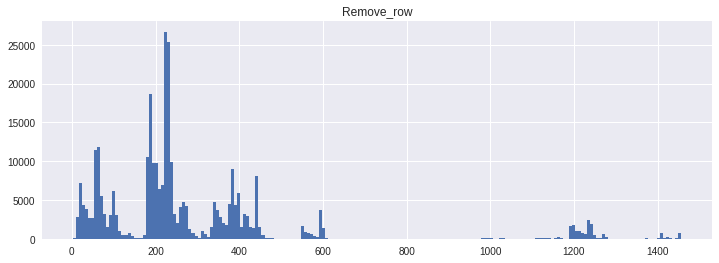

In [10]:
df.hist(column="Remove_row",bins=200)

In [11]:
len(df)

307511

In [12]:
df.shape

(307511, 1707)

In [14]:
len(df[df["Remove_row"]<= 1100])

291640

In [18]:
len(df[df["Remove_row"]<= 1100])/len(df)

0.9483888381228639

In [19]:
df = df[df["Remove_row"]<= 1100 ]

In [20]:
len(df)

291640

In [21]:
#remove "Unnamed: 0"
if "Remove_row" in list(df):
    df = df.drop("Remove_row", axis=1)
    

# Drop highly correlated features

In [67]:
df_cor = df.corr()

In [68]:
features_to_reduce = list(set(df_cor.columns))
features_to_reduce2 = list(set(df_cor.columns))

In [69]:
features_to_reduce

['credit_card_NAME_CONTRACT_STATUS_Unused offer_count',
 'credit_card_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_min',
 'credit_card_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum',
 'bureau_CREDIT_TYPE_Cash loan (non-earmarked)_var',
 'ORGANIZATION_TYPE_Emergency',
 'credit_card_DAYS_TERMINATION_max',
 'FLAG_DOCUMENT_11',
 'bureau_CREDIT_TYPE_Real estate loan_sum',
 'credit_card_CODE_REJECT_REASON_SCO_max',
 'bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_min',
 'credit_card_NAME_TYPE_SUITE_Children_count',
 'REG_REGION_NOT_WORK_REGION',
 'credit_card_NAME_GOODS_CATEGORY_Tourism_max',
 'bureau_AMT_CREDIT_SUM_OVERDUE_size',
 'credit_card_AMT_DRAWINGS_ATM_CURRENT_min',
 'credit_card_AMT_DRAWINGS_OTHER_CURRENT_var',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'credit_card_CHANNEL_TYPE_Stone_var',
 'credit_card_AMT_DRAWINGS_ATM_CURRENT_sum',
 'bureau_AMT_CREDIT_SUM_OVERDUE_var',
 'credit_card_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_count',
 'credit_card_NAME_G

In [70]:
#df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

In [71]:
df_cor = df_cor.abs()

In [72]:
df_cor.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
TARGET,1.000000,0.019187,0.003982,0.030369,0.012817,0.039645,0.037227,0.078239,0.074958,0.041975,...,0.005580,0.004676,0.001626,0.006114,0.001727,0.000598,0.000510,0.000811,0.004590,0.001414
CNT_CHILDREN,0.019187,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.061145,0.183395,...,0.014060,0.013800,0.010871,0.009075,0.000626,0.003556,0.002057,0.002821,0.002504,0.001812
AMT_INCOME_TOTAL,0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,0.013005,0.027805,...,0.004873,0.004089,0.004028,0.003064,0.000137,0.001030,0.001185,0.000925,0.000185,0.001066
AMT_CREDIT,0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,0.055436,0.091295,0.009621,...,0.013533,0.009960,0.009995,0.005640,0.001577,0.004093,0.004141,0.001061,0.001808,0.001201
AMT_ANNUITY,0.012817,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,0.053604,0.038514,...,0.006909,0.003668,0.003018,0.001521,0.002393,0.001014,0.002279,0.000973,0.002831,0.002525


In [73]:
# Upper triangle of correlations
upper = df_cor.where(np.triu(np.ones(df_cor.shape), k=1).astype(np.bool))
upper.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
TARGET,NaN,0.019187,0.003982,0.030369,0.012817,0.039645,0.037227,0.078239,0.074958,0.041975,...,0.005580,0.004676,0.001626,0.006114,0.001727,0.000598,0.000510,0.000811,0.004590,0.001414
CNT_CHILDREN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.061145,0.183395,...,0.014060,0.013800,0.010871,0.009075,0.000626,0.003556,0.002057,0.002821,0.002504,0.001812
AMT_INCOME_TOTAL,NaN,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,0.013005,0.027805,...,0.004873,0.004089,0.004028,0.003064,0.000137,0.001030,0.001185,0.000925,0.000185,0.001066
AMT_CREDIT,NaN,NaN,NaN,NaN,0.770138,0.986968,0.099738,0.055436,0.091295,0.009621,...,0.013533,0.009960,0.009995,0.005640,0.001577,0.004093,0.004141,0.001061,0.001808,0.001201
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,0.775109,0.118429,0.009445,0.053604,0.038514,...,0.006909,0.003668,0.003018,0.001521,0.002393,0.001014,0.002279,0.000973,0.002831,0.002525


In [75]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 508 columns to remove.


In [76]:
to_drop

['AMT_GOODS_PRICE',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DAYS_EMPLOYED_PERC',
 'bureau_DAYS_CREDIT_size',
 'bureau_CREDIT_DAY_OVERDUE_count',
 'bureau_CREDIT_DAY_OVERDUE_sum',
 'bureau_CREDIT_DAY_OVERDUE_size',
 'bureau_CREDIT_DAY_OVERDUE_var',
 'bureau_DAYS_CREDIT_ENDDATE_count',
 'bureau_DAYS_CREDIT_ENDDATE_size',
 'bureau_DAYS_ENDDATE_FACT_size',
 'bureau_AMT_CREDIT_MAX_OVERDUE_max',


In [77]:
df = df.drop(to_drop, axis=1)
df2 = df2.drop(to_drop, axis=1)


In [78]:
# quick recovery: df2 = pd.read_csv("Data/V2.0_test.csv")

In [79]:
df.to_csv("Data/V3.noCorr_train.csv")
df2.to_csv("Data/V3.noCorr_train.csv")

# Process the nan entries

In [22]:
df.fillna(9999999999, inplace=True)

In [23]:
df2.fillna(9999999999, inplace=True)

In [24]:
df.shape

(291640, 1706)

In [25]:
df2.shape

(48744, 1705)

In [26]:
df.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,...,0,0,0,0,0,0,0,0,0,0


# Use XGBOOST

In [27]:
y_train = df["TARGET"].values

In [28]:
if "TARGET" in list(df):
    df = df.drop("TARGET", axis=1)

# Is it first pass or not?

In [29]:
FirstPass = True

if (FirstPass): 
    x_train = df
else:
    x_train = df[feature_importance.index[0:530]]
    list_of_preferred_features = feature_importance.index[0:530]
    len(list_of_preferred_features.unique())
    list_of_preferred_features
    #x_train = df[list_of_preferred_features]

In [30]:
#len(feature_importance[0:530])


In [31]:
x_train.shape

(291640, 1705)

In [32]:
x_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,...,0,0,0,0,0,0,0,0,0,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,...,0,0,0,0,0,0,0,0,0,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,...,0,0,0,0,0,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,...,0,0,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,...,0,0,0,0,0,0,0,0,0,0


In [33]:
d_train = xgb.DMatrix(x_train, label=y_train)

In [34]:

if (FirstPass):
    feature_importance = []

In [35]:
def modelfit(alg,dtrain,x_train,y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds = 50):
    
    if useTrainCV:
        xgb_params = alg.get_xgb_params()
        xgtrain = d_train
        cvresults = xgb.cv(xgb_params, xgtrain, 
                           num_boost_round=alg.get_params()['n_estimators'], 
                           nfold=cv_folds, 
                           metrics=['auc'],
                           early_stopping_rounds=early_stopping_rounds,
                           verbose_eval = 5#,
                           #stratified=False #, TO TRY with different parameters
                           )
        
        alg.set_params(n_estimators = cvresults.shape[0] ) 
        
        #fit the algorithm on the data
        alg.fit(x_train, y_train, eval_metric='auc')
        
        print('Overall AUC:', roc_auc_score(y_train, alg.predict_proba(x_train)[:,1]))
        print('Overall Accuracy:', accuracy_score(y_train, alg.predict(x_train)))
        
        feature_importance = pd.Series(alg.booster().get_fscore()).sort_values(ascending = False)
        feature_importance[0:100].plot(kind = 'bar', title = 'Features importance')
        plt.ylabel('Features importance Score')
        return feature_importance
        

In [36]:
xgb1 = xgb.XGBClassifier(
                missing=9999999999, #9999999999,
                learning_rate=0.1,
                max_depth = 5,
                n_estimators=1000,            
                #colsample_bytree=0.5,
                min_child_weight = 1,#3
                gamma = 0,
                subsample = 0.8,
                objective = 'binary:logistic',
                nthread=4,
                reg_lambda = 0.02, 
                scale_pos_weight= 2, #10,1
                reg_alpha= 0.005,##reg_alpha= 0.005
                seed=1301)


In [43]:
xgb1 = xgb.XGBClassifier(
            missing=9999999999,
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            #leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            #objective = 'binary:logistic',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            #min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            #verbose=-1,
            seed=1301)

In [44]:
#play with hyperameters

[0]	train-auc:0.735264+0.00241502	test-auc:0.706297+0.00361134
[5]	train-auc:0.762757+0.00221119	test-auc:0.73103+0.00578599
[10]	train-auc:0.768745+0.00180826	test-auc:0.736042+0.00415683
[15]	train-auc:0.770907+0.00180174	test-auc:0.737555+0.00426348
[20]	train-auc:0.772995+0.00170835	test-auc:0.738878+0.00370035
[25]	train-auc:0.774956+0.000953587	test-auc:0.740139+0.00415112
[30]	train-auc:0.777245+0.00106598	test-auc:0.741488+0.00407329
[35]	train-auc:0.779728+0.00127699	test-auc:0.742723+0.00443722
[40]	train-auc:0.780849+0.00106713	test-auc:0.743343+0.00438297
[45]	train-auc:0.782592+0.00101017	test-auc:0.744527+0.00447995
[50]	train-auc:0.784353+0.00115624	test-auc:0.745484+0.00438681
[55]	train-auc:0.785722+0.00107197	test-auc:0.746062+0.0043952
[60]	train-auc:0.787301+0.000782813	test-auc:0.746916+0.00446847
[65]	train-auc:0.788817+0.00091508	test-auc:0.747716+0.00445495
[70]	train-auc:0.790574+0.00101208	test-auc:0.748616+0.00443223
[75]	train-auc:0.792267+0.00106216	test-au

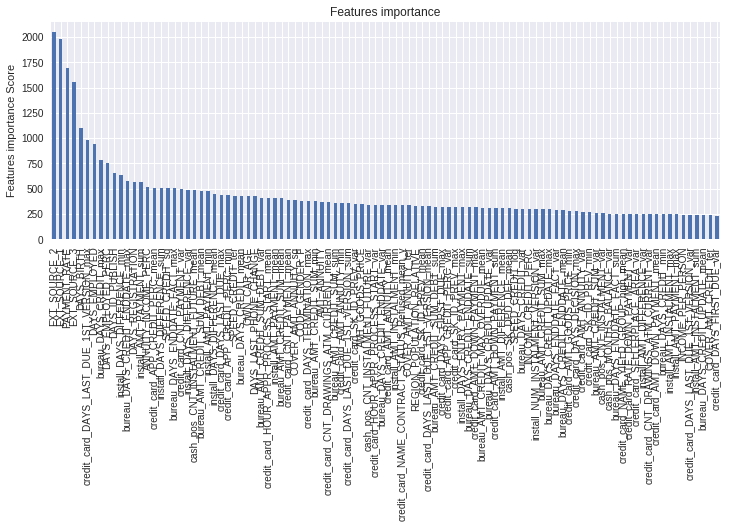

In [45]:
feature_importance = modelfit(xgb1,d_train,x_train, y_train)

## keep following for benchmark purposes

[0]	train-auc:0.721116+0.00105089	test-auc:0.716496+0.00369264
[5]	train-auc:0.737743+0.00119745	test-auc:0.72921+0.00347993
[10]	train-auc:0.744734+0.00107908	test-auc:0.73385+0.00329917
[15]	train-auc:0.750822+0.00110203	test-auc:0.7385+0.00314218
[20]	train-auc:0.757384+0.00139716	test-auc:0.743186+0.00322848
[25]	train-auc:0.76423+0.00130412	test-auc:0.747954+0.00403152
[30]	train-auc:0.771787+0.00164654	test-auc:0.753711+0.00368684
[35]	train-auc:0.778581+0.00131715	test-auc:0.758519+0.0039737
[40]	train-auc:0.784589+0.00131297	test-auc:0.762348+0.00404228
[45]	train-auc:0.789368+0.00131247	test-auc:0.765268+0.00415575
[50]	train-auc:0.793877+0.00128112	test-auc:0.767711+0.0041858
[55]	train-auc:0.797661+0.00130201	test-auc:0.769701+0.00438978
[60]	train-auc:0.801294+0.00112268	test-auc:0.771376+0.0044549
[65]	train-auc:0.804417+0.00101889	test-auc:0.772681+0.00457045
[70]	train-auc:0.807486+0.00102595	test-auc:0.774+0.00441483
[75]	train-auc:0.81029+0.000877837	test-auc:0.775012+

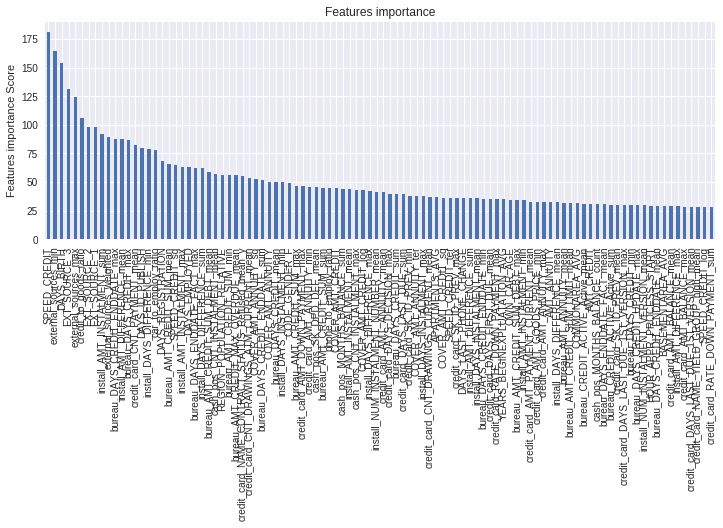

In [45]:
feature_importance = modelfit(xgb1,d_train,x_train, y_train)

[0]	train-auc:0.711513+0.000942919	test-auc:0.706475+0.00386037
[5]	train-auc:0.731867+0.00060683	test-auc:0.725117+0.00131971
[10]	train-auc:0.739407+0.000599025	test-auc:0.731657+0.00082724
[15]	train-auc:0.745392+0.000705801	test-auc:0.736057+0.000915461
[20]	train-auc:0.753258+0.000705492	test-auc:0.741681+0.00137792
[25]	train-auc:0.761527+0.000720989	test-auc:0.747329+0.00141496
[30]	train-auc:0.768935+0.000786935	test-auc:0.752781+0.0016328
[35]	train-auc:0.776205+0.000707746	test-auc:0.758257+0.0014582
[40]	train-auc:0.781976+0.000513509	test-auc:0.762058+0.00188025
[45]	train-auc:0.786942+0.000679627	test-auc:0.765155+0.00180345
[50]	train-auc:0.791458+0.000631274	test-auc:0.767902+0.00185627
[55]	train-auc:0.795238+0.00083915	test-auc:0.769959+0.001757
[60]	train-auc:0.798727+0.000772537	test-auc:0.771539+0.00195169
[65]	train-auc:0.801904+0.000705808	test-auc:0.772979+0.00207944
[70]	train-auc:0.804861+0.00083771	test-auc:0.774296+0.00211375
[75]	train-auc:0.807733+0.0009287

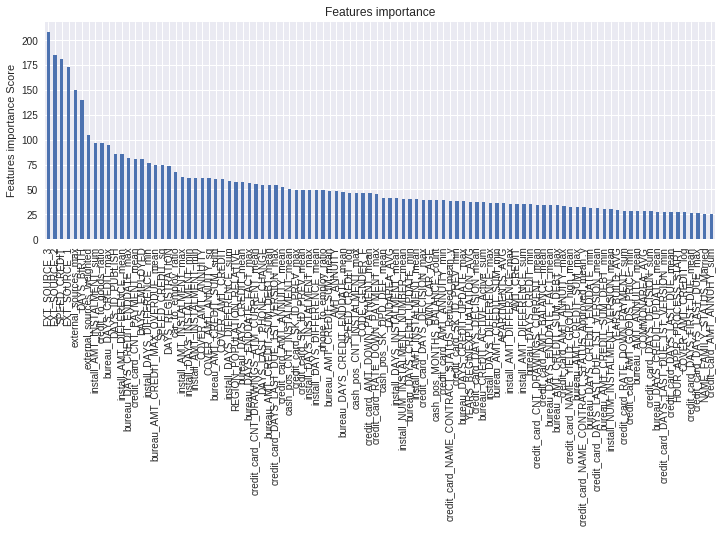

In [57]:
feature_importance = modelfit(xgb1,d_train,x_train, y_train)

In [46]:
fields_not_important = feature_importance[-800:]
fields_not_important.index[0:10]

Index(['install_DAYS_DIFFERENCE_sum', 'SPEED_CREDIT_sq',
       'bureau_DAYS_ENDDATE_FACT_max', 'credit_card_CNT_PAYMENT_var',
       'install_DAYS_DIFFERENCE_var', 'cash_pos_CNT_INSTALMENT_FUTURE_mean',
       'bureau_AMT_CREDIT_SUM_DEBT_mean', 'install_AMT_PAYMENT_min',
       'install_DAYS_DIFFERENCE_mean', 'credit_card_DAYS_LAST_DUE_max'],
      dtype='object')

# Predict the results for test data:

In [47]:
df2.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329.0,-5170.0,-812,...,0,0,0,0,0,0,0,0,0,0
1,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469.0,-9118.0,-1623,...,0,0,0,0,0,0,0,0,0,0
2,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458.0,-2175.0,-3503,...,0,0,0,0,0,0,0,0,0,0
3,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866.0,-2000.0,-4208,...,0,0,0,0,0,0,0,0,0,0
4,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191.0,-4000.0,-4262,...,0,0,0,0,0,0,0,0,0,0


In [48]:
if "SK_ID_CURR" in list(df2):
    df2 = df2.drop("SK_ID_CURR", axis=1)   

In [49]:
#quick fix df2 = df2.drop("Unnamed: 0", axis=1)

In [50]:
FirstPass

True

In [51]:
if(FirstPass):
    x_predict = df2
else:
    x_predict = df2[feature_importance.index[0:530]]

In [52]:
missing_categories = list(set(x_predict.columns) - set(x_train.columns))
#missing_categories.remove("TARGET")
print(missing_categories)

[]


In [53]:
x_predict.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AMT_REQ_CREDIT_BUREAU_YEAR_6.0,AMT_REQ_CREDIT_BUREAU_YEAR_7.0,AMT_REQ_CREDIT_BUREAU_YEAR_8.0,AMT_REQ_CREDIT_BUREAU_YEAR_9.0,AMT_REQ_CREDIT_BUREAU_YEAR_10.0,AMT_REQ_CREDIT_BUREAU_YEAR_11.0,AMT_REQ_CREDIT_BUREAU_YEAR_12.0,AMT_REQ_CREDIT_BUREAU_YEAR_13.0,AMT_REQ_CREDIT_BUREAU_YEAR_14.0,AMT_REQ_CREDIT_BUREAU_YEAR_17.0
0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329.0,-5170.0,-812,...,0,0,0,0,0,0,0,0,0,0
1,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469.0,-9118.0,-1623,...,0,0,0,0,0,0,0,0,0,0
2,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458.0,-2175.0,-3503,...,0,0,0,0,0,0,0,0,0,0
3,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866.0,-2000.0,-4208,...,0,0,0,0,0,0,0,0,0,0
4,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191.0,-4000.0,-4262,...,0,0,0,0,0,0,0,0,0,0


In [54]:
pred = xgb1.predict_proba(x_predict)

In [55]:
df_submit = pd.read_csv("Data/sample_submission.csv")

In [56]:
df_submit["TARGET"] = pred[:,1]
df_submit.head()

,SK_ID_CURR,TARGET
0,100001,0.026948
1,100005,0.118131
2,100013,0.029500
3,100028,0.046503
4,100038,0.171137


In [57]:
pred[:,1]

array([ 0.02694768,  0.1181308 ,  0.02950012, ...,  0.0065392 ,
        0.02972595,  0.18013467], dtype=float32)

In [58]:
df_submit["TARGET"].describe()

count    48744.000000
mean         0.073248
std          0.085394
min          0.001263
25%          0.020809
50%          0.042200
75%          0.090418
max          0.779766
Name: TARGET, dtype: float64

In [59]:
df_submit.to_csv("Data/v3.0.submission_prediction2507.csv", index = False)

# Blend

In [194]:
df_part1 = pd.read_csv("Data/v3.0.submission_prediction.csv")
df_part1.head()

,SK_ID_CURR,TARGET
0,100001,0.160554
1,100005,0.571323
2,100013,0.211340
3,100028,0.394780
4,100038,0.638120


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc81e052be0>]], dtype=object)

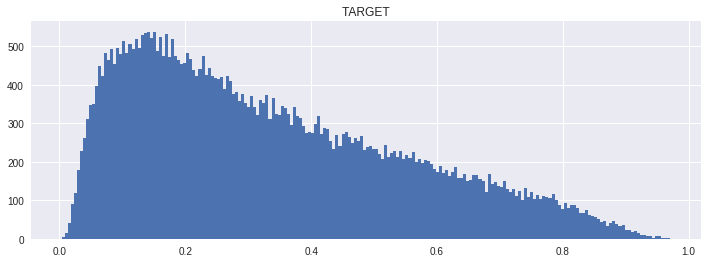

In [213]:
df_part1.hist(column='TARGET',bins=200)

In [209]:
df_part2 = pd.read_csv("Data/v3.0.submission_prediction_lightGB.csv")
df_part2.head()

,SK_ID_CURR,TARGET
0,100001,0.318619
1,100005,0.663059
2,100013,0.137330
3,100028,0.235745
4,100038,0.628501


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc81dfe4e48>]], dtype=object)

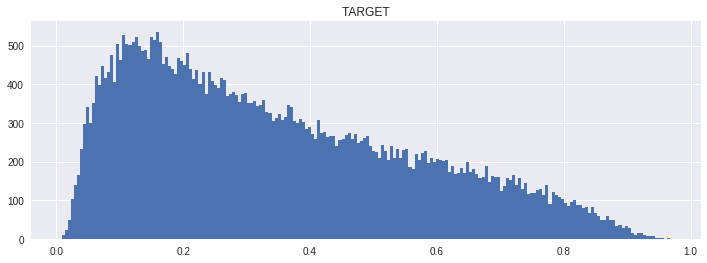

In [214]:
df_part2.hist(column='TARGET',bins=200)

In [210]:
df_part2["TARGET"] = (0.7*df_part2["TARGET"] + 0.3*df_part1["TARGET"]) 

In [211]:
df_part2.head()

,SK_ID_CURR,TARGET
0,100001,0.271199
1,100005,0.635538
2,100013,0.159533
3,100028,0.283455
4,100038,0.631386


In [212]:
df_part2.to_csv("Data/v3.0.submission_prediction_b.csv", index = False)

## Order Test the same as  Train so we have the same consistent column order for both

/home/gilles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/gilles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/gilles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


The correlation between COVER_AMT_GOODS_PRICE and the TARGET is 0.0108
Median value for loan that was not repaid = 0.0001
Median value for loan that was repaid =     0.0001


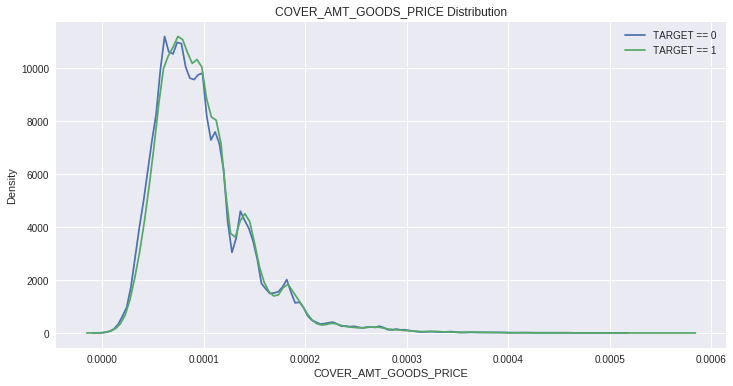

In [199]:
kde_target("COVER_AMT_GOODS_PRICE",df)

/home/gilles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


The correlation between FLAG_DOCUMENT_7 and the TARGET is -0.0015
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


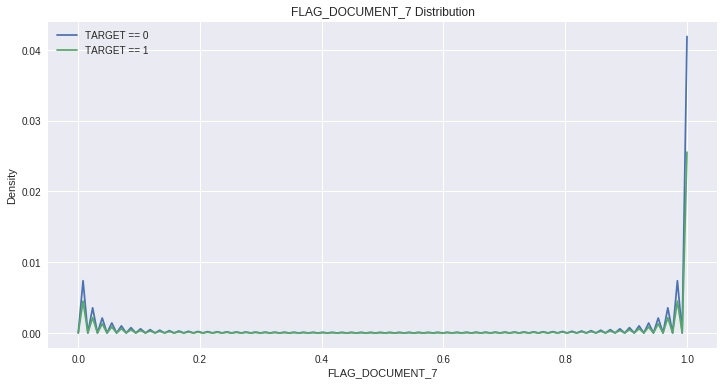

In [52]:
kde_target("AMT_REQ_CREDIT_BUREAU_YEAR",df)

/home/gilles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/gilles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/gilles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


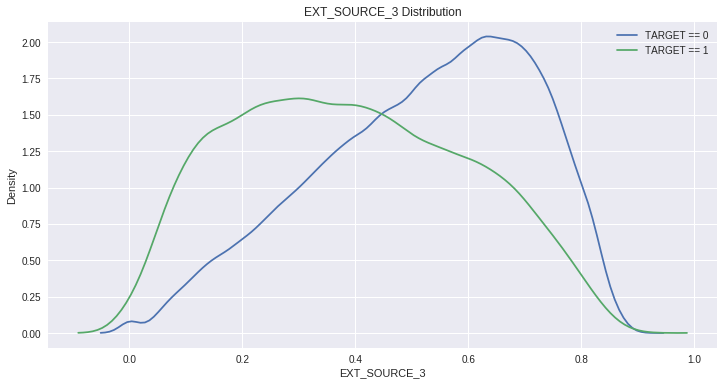

In [42]:
kde_target("EXT_SOURCE_3",df)

In [8]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Process the missing data

In [4]:
for i in range(len(df.columns)):
    column_name = df.columns[i]
    if (df[column_name].isnull().sum()!=0):
        print (column_name, df[column_name].isnull().sum())

AMT_ANNUITY 12
AMT_GOODS_PRICE 278
NAME_TYPE_SUITE 1292
OWN_CAR_AGE 202929
OCCUPATION_TYPE 96391
CNT_FAM_MEMBERS 2
EXT_SOURCE_1 173378
EXT_SOURCE_2 660
EXT_SOURCE_3 60965
APARTMENTS_AVG 156061
BASEMENTAREA_AVG 179943
YEARS_BEGINEXPLUATATION_AVG 150007
YEARS_BUILD_AVG 204488
COMMONAREA_AVG 214865
ELEVATORS_AVG 163891
ENTRANCES_AVG 154828
FLOORSMAX_AVG 153020
FLOORSMIN_AVG 208642
LANDAREA_AVG 182590
LIVINGAPARTMENTS_AVG 210199
LIVINGAREA_AVG 154350
NONLIVINGAPARTMENTS_AVG 213514
NONLIVINGAREA_AVG 169682
APARTMENTS_MODE 156061
BASEMENTAREA_MODE 179943
YEARS_BEGINEXPLUATATION_MODE 150007
YEARS_BUILD_MODE 204488
COMMONAREA_MODE 214865
ELEVATORS_MODE 163891
ENTRANCES_MODE 154828
FLOORSMAX_MODE 153020
FLOORSMIN_MODE 208642
LANDAREA_MODE 182590
LIVINGAPARTMENTS_MODE 210199
LIVINGAREA_MODE 154350
NONLIVINGAPARTMENTS_MODE 213514
NONLIVINGAREA_MODE 169682
APARTMENTS_MEDI 156061
BASEMENTAREA_MEDI 179943
YEARS_BEGINEXPLUATATION_MEDI 150007
YEARS_BUILD_MEDI 204488
COMMONAREA_MEDI 214865
ELEVATORS_ME

## Initial transformations:

a) put in categories:

     REGION_RATING_CLIENT

     REGION_RATING_CLIENT_W_CITY

b)CNT_FAM_MEMBERS: mode

c)NAME_TYPE_SUITE: others_C

d)OWN_CAR_AGE: 0 but introduce field with CAR_INFO: 0/1

e)for living area, fill everything with 0 but introduce HOUSING_INFO: 0/1 possible issues here...

f) OCCUPATION_TYPE: "none_recorded"

g) for EXT_SOURCE_1,2,3:
    
    if data is present, put a categorical flag 0/1 and fill with 0 missing values


### First series of easy to fill missing data

In [5]:
df['AMT_ANNUITY'].fillna((df['AMT_ANNUITY'].mean()), inplace=True)
df['AMT_GOODS_PRICE'].fillna(df['AMT_GOODS_PRICE'].median(), inplace=True)
df['NAME_TYPE_SUITE'].fillna("others_C", inplace=True)
df['OCCUPATION_TYPE'].fillna("None_recorded", inplace=True)
df['CNT_FAM_MEMBERS'].fillna(2, inplace=True)


### Second series where missing data information must be signaled

In [6]:
def indicate_presence(field):
    return int(field.isnull())

In [7]:
df["OWN_CAR_AGE_INFO"]= df['OWN_CAR_AGE'].notnull().astype(int)

In [8]:
df["OWN_CAR_AGE_INFO"] 
df['OWN_CAR_AGE'].fillna(0, inplace=True)

In [9]:
df["EXT_SOURCE_1_INFO"]= df['EXT_SOURCE_1'].notnull().astype(int)
df["EXT_SOURCE_2_INFO"]= df['EXT_SOURCE_2'].notnull().astype(int)
df["EXT_SOURCE_3_INFO"]= df['EXT_SOURCE_3'].notnull().astype(int)

In [10]:
df['EXT_SOURCE_1'].fillna(0.0, inplace=True)
df['EXT_SOURCE_2'].fillna(0.0, inplace=True)
df['EXT_SOURCE_3'].fillna(0.0, inplace=True)

## Add "not recorded" for categorical data

In [11]:
categories= ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR",
             "FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE",
             "NAME_FAMILY_STATUS","NAME_HOUSING_TYPE", "NAME_TYPE_SUITE",
            "OCCUPATION_TYPE","WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE",
            "FONDKAPREMONT_MODE","HOUSETYPE_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE"]

for i in categories:
    df[i].fillna("Not_recorded", inplace=True)

In [12]:
df["DAYS_LAST_PHONE_CHANGE"].fillna(0, inplace=True)

In [13]:
fields_missing = ["APARTMENTS_AVG", "BASEMENTAREA_AVG","YEARS_BEGINEXPLUATATION_AVG","YEARS_BUILD_AVG",
                  "COMMONAREA_AVG","ELEVATORS_AVG","ENTRANCES_AVG","FLOORSMAX_AVG","FLOORSMIN_AVG","LANDAREA_AVG",
                  "LIVINGAPARTMENTS_AVG","LIVINGAREA_AVG","NONLIVINGAPARTMENTS_AVG","NONLIVINGAREA_AVG","APARTMENTS_MODE",
                  "BASEMENTAREA_MODE","YEARS_BEGINEXPLUATATION_MODE","YEARS_BUILD_MODE","COMMONAREA_MODE",
                  "ELEVATORS_MODE","ENTRANCES_MODE","FLOORSMAX_MODE",'FLOORSMIN_MODE',"LANDAREA_MODE",
                  "LIVINGAPARTMENTS_MODE","LIVINGAREA_MODE","NONLIVINGAPARTMENTS_MODE","NONLIVINGAREA_MODE",
                  "APARTMENTS_MEDI","BASEMENTAREA_MEDI","YEARS_BEGINEXPLUATATION_MEDI","YEARS_BUILD_MEDI",
                  "COMMONAREA_MEDI","ELEVATORS_MEDI","ENTRANCES_MEDI",
                  "FLOORSMAX_MEDI","FLOORSMIN_MEDI","LANDAREA_MEDI","LIVINGAPARTMENTS_MEDI","LIVINGAREA_MEDI",
                  "NONLIVINGAPARTMENTS_MEDI","NONLIVINGAREA_MEDI","FONDKAPREMONT_MODE","HOUSETYPE_MODE",
                  "TOTALAREA_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE","OBS_30_CNT_SOCIAL_CIRCLE",
                  "DEF_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"]


In [14]:
for i in fields_missing:
    field_name = i + '_INFO'
    df[field_name]= df[i].notnull().astype(int)
    df[i].fillna(0, inplace=True)

In [15]:
for i in range(len(df.columns)):
    column_name = df.columns[i]
    if (df[column_name].isnull().sum()!=0):
        print (column_name, df[column_name].isnull().sum())

AMT_REQ_CREDIT_BUREAU_HOUR 41519
AMT_REQ_CREDIT_BUREAU_DAY 41519
AMT_REQ_CREDIT_BUREAU_WEEK 41519
AMT_REQ_CREDIT_BUREAU_MON 41519
AMT_REQ_CREDIT_BUREAU_QRT 41519
AMT_REQ_CREDIT_BUREAU_YEAR 41519


## Remove(!!!) those columns

AMT_REQ_CREDIT_BUREAU_HOUR

AMT_REQ_CREDIT_BUREAU_DAY

AMT_REQ_CREDIT_BUREAU_WEEK

AMT_REQ_CREDIT_BUREAU_MON

AMT_REQ_CREDIT_BUREAU_QRT

AMT_REQ_CREDIT_BUREAU_YEAR

In [16]:
AMT_fields = ["AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY",
"AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON",
"AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"]


for i in AMT_fields:
     df = df.drop(i, 1)

## Check that we don't have any missing values anymore

In [17]:
for i in range(len(df.columns)):
    column_name = df.columns[i]
    if (df[column_name].isnull().sum()!=0):
        print (column_name, df[column_name].isnull().sum())

### Process the categorical data (changed in V1.1)

Add to categories:

REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY

In [18]:
categories= ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR",
             "FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE",
             "NAME_FAMILY_STATUS","NAME_HOUSING_TYPE", "NAME_TYPE_SUITE",
             "OCCUPATION_TYPE","WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE",
             "FONDKAPREMONT_MODE","HOUSETYPE_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE",
             "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"
            ]

for i in categories:
    dummy = pd.get_dummies(df[i],prefix_sep='_', prefix=i)
    df = pd.concat([df,dummy],axis=1)
    df = df.drop(i, 1)

In [19]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Not_recorded,EMERGENCYSTATE_MODE_Yes,REGION_RATING_CLIENT_1,REGION_RATING_CLIENT_2,REGION_RATING_CLIENT_3,REGION_RATING_CLIENT_W_CITY_1,REGION_RATING_CLIENT_W_CITY_2,REGION_RATING_CLIENT_W_CITY_3
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,1,0,0,0,1,0,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,1,0,0,1,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,1,0,0,1,0,0,1,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,1,0,0,1,0,0,1,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,1,0,0,1,0,0,1,0


# Feature Engineering...

### Add the ratio between anuity, credit, goods / income

In [20]:
df["COVER_AMT_CREDIT"] = df["AMT_CREDIT"]/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_ANNUITY"] = df["AMT_ANNUITY"]/df["AMT_INCOME_TOTAL"]
df["COVER_AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"]/df["AMT_INCOME_TOTAL"]
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,EMERGENCYSTATE_MODE_Yes,REGION_RATING_CLIENT_1,REGION_RATING_CLIENT_2,REGION_RATING_CLIENT_3,REGION_RATING_CLIENT_W_CITY_1,REGION_RATING_CLIENT_W_CITY_2,REGION_RATING_CLIENT_W_CITY_3,COVER_AMT_CREDIT,COVER_AMT_ANNUITY,COVER_AMT_GOODS_PRICE
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,1,0,0,1,0,2.007889,0.121978,1.733333
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,1,0,0,4.790750,0.132217,4.183333
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,1,0,0,1,0,2.000000,0.100000,2.000000
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,1,0,0,1,0,2.316167,0.219900,2.200000
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,1,0,0,1,0,4.222222,0.179963,4.222222


## save everything...

In [21]:
## df.to_csv("Data/V1.1.transformed_application_train.csv")

In [22]:
for i in range(len(df.columns)):
    print (df.columns[i])

SK_ID_CURR
TARGET
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_ME

# USE XGB...

In [23]:
import xgboost as xgb

/home/gilles/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
y_train = df["TARGET"].values

In [25]:
x_train = df.drop("TARGET", axis=1)

In [26]:
print(x_train.shape, y_train.shape)

(307511, 307) (307511,)


In [42]:
d_train = xgb.DMatrix(x_train, label=y_train)
#d_valid = xgb.DMatrix(x_valid, label=y_valid)

In [44]:
from sklearn.grid_search import GridSearchCV

/home/gilles/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [50]:
xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.9,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'silent': 1,
        'colsample_bytree': 0.9
    }

In [51]:
cvresult = xgb.cv(xgb_params, d_train, num_boost_round=5000, nfold=5, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=1301)

In [52]:
print('Best number of trees = {}'.format(cvresult.shape[0]))

Best number of trees = 555


In [55]:
clf.set_params(n_estimators=cvresult.shape[0])
print('Fit on the training data')


Fit on the training data


In [59]:
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=1301)
xgb_param = clf.get_xgb_params()



TypeError: set_params() takes 1 positional argument but 2 were given

In [56]:
clf.fit(x_train, y_train, eval_metric='auc')
print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))

NameError: name 'roc_auc_score' is not defined

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(x_train)[:,1]))

Overall AUC: 0.905350371457


In [ ]:
print('Predict the probabilities based on features in the test set')
pred = clf.predict_proba(sel_test, ntree_limit=cvresult.shape[0])

submission = pd.DataFrame({"ID":test.index, "TARGET":pred[:,1]})
submission.to_csv("submission.csv", index=False)


In [48]:
#dtrain <- xgb.DMatrix(agaricus.train$data, label = agaricus.train$label)
cv = xgb.cv(xgb_params, d_train, nrounds = 3, nthread = 2, nfold = 5, metrics = ["auc"],
                  max_depth = 3, eta = 1, objective = "binary:logistic")
print(cv)
print(cv, verbose=TRUE)

TypeError: cv() got an unexpected keyword argument 'data'

In [ ]:
#do cross validation
print ('Start cross validation')
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=1301)
print('Best number of trees = {}'.format(cvresult.shape[0]))
clf.set_params(n_estimators=cvresult.shape[0])
print('Fit on the trainingsdata')
clf.fit(X_sel, y, eval_metric='auc')
print('Overall AUC:', roc_auc_score(y, clf.predict_proba(X_sel)[:,1]))


In [28]:
from sklearn.model_selection import KFold
K = 5
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [38]:
for train_index, test_index in kf.split(x_train):
    print(train_index)

[     0      1      2 ..., 307508 307509 307510]
[     0      1      2 ..., 307508 307509 307510]
[     0      2      3 ..., 307508 307509 307510]
[     0      1      2 ..., 307505 307507 307508]
[     1      4      5 ..., 307507 307509 307510]


In [39]:
watchlist =[]
for train_index, test_index in kf.split(x_train):
#    train_X, valid_X = train[train_index], train[test_index]
#    train_y, valid_y = target_train[train_index], target_train[test_index]
        train_X, valid_X = x_train[train_index], x_train[test_index]
        train_y, valid_y = y_train[train_index], y_train[test_index]
        d_train = xgb.DMatrix(train_X, train_y)
        d_valid = xgb.DMatrix(valid_X, valid_y)
#        d_test = xgb.DMatrix(test)
    
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        model = xgb.train(xgb_params, d_train, 10000, evals = watchlist,
                          early_stopping_rounds=100, verbose_eval=10)
                        
#        xgb_pred = model.predict(d_test)
#       xgb_preds.append(list(xgb_pred))



IndexError: indices are out-of-bounds

In [ ]:
#watchlist = [(d_train, 'train'), (d_valid, 'valid')]
#clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)


In [ ]:


#xgb_preds = []


#preds=[]
#for i in range(len(xgb_preds[0])):
#    sum=0
#    for j in range(K):
#        sum+=xgb_preds[j][i]
#    preds.append(sum / K)

#output = pd.DataFrame({'id': id_test, 'target': preds})
#output.to_csv("{}-foldCV_sub.csv".format(K), index=False)   


In [67]:
split = 200000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

In [68]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)


In [69]:
# specify parameters via map
#param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
#num_round = 2
#bst = xgb.train(param, dtrain, num_round)
# make prediction
#preds = bst.predict(dtest)



In [70]:
params = {}
params['eta'] = 0.02
params['objective'] = 'binary:logistic'#'reg:linear'
params['eval_metric'] = 'auc'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)


[0]	train-auc:0.698515	valid-auc:0.701202
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.707155	valid-auc:0.70888
[20]	train-auc:0.712788	valid-auc:0.714733
[30]	train-auc:0.715496	valid-auc:0.717656
[40]	train-auc:0.717108	valid-auc:0.71893
[50]	train-auc:0.718271	valid-auc:0.720174
[60]	train-auc:0.719355	valid-auc:0.721145
[70]	train-auc:0.720619	valid-auc:0.722318
[80]	train-auc:0.721864	valid-auc:0.723569
[90]	train-auc:0.723447	valid-auc:0.725044
[100]	train-auc:0.725052	valid-auc:0.72635
[110]	train-auc:0.726682	valid-auc:0.727812
[120]	train-auc:0.728244	valid-auc:0.729347
[130]	train-auc:0.729774	valid-auc:0.730593
[140]	train-auc:0.731552	valid-auc:0.732023
[150]	train-auc:0.734115	valid-auc:0.734217
[160]	train-auc:0.736718	valid-auc:0.736361
[170]	train-auc:0.73919	valid-auc:0.738417
[180]	train-auc:0.741334	valid-auc:0.74012
[190]	train-auc:0.743296	valid-auc:0

In [132]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [133]:
import operator
from matplotlib import pylab as plt

In [134]:
create_feature_map(x_train.columns)

In [135]:
importance = clf.get_fscore(fmap='xgb.fmap')

importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
plt.show()

XGBoostError: b'[18:46:52] include/xgboost/././feature_map.h:83: unknown feature type, use i for indicator and q for quantity'

In [136]:
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))

plt.title('XGBoost Feature Importance')

plt.xlabel('relative importance')
plt.show()
#plt.gcf().savefig('feature_importance_xgb.png')

KeyError: 'feature'

In [124]:
preds = clf.predict(d_valid)

In [125]:
preds

array([ 0.11258963,  0.02711681,  0.06188182, ...,  0.05634286,
        0.06423247,  0.08309193], dtype=float32)

In [ ]:
print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

#del df_train; gc.collect()

split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

In [13]:
df["TARGET"].describe()

count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [148]:
df[df["OWN_CAR_AGE"].isnull()==False]["TARGET"].describe()

count    104582.000000
mean          0.072441
std           0.259218
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [149]:
df[df["OWN_CAR_AGE"].isnull()]["TARGET"].describe()

count    202929.000000
mean          0.085000
std           0.278883
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [37]:
307511 - 24825

282686

In [39]:
df[df["TARGET"]==1].describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,24825.0,24825.000000,2.482500e+04,2.482500e+04,24825.000000,2.480400e+04,24825.000000,24825.000000,24825.000000,24825.000000,...,24825.000000,24825.000000,24825.000000,24825.000000,20533.000000,20533.000000,20533.000000,20533.000000,20533.000000,20533.000000
mean,1.0,0.463807,1.656118e+05,5.577785e+05,26481.744290,4.889724e+05,0.019131,-14884.828077,42394.675448,-4487.127009,...,0.005720,0.000483,0.000524,0.000564,0.006672,0.008036,0.034919,0.227926,0.259923,2.028783
std,0.0,0.756903,7.466770e+05,3.464332e+05,12450.676999,3.116365e+05,0.011905,4192.844583,119484.634253,3299.650241,...,0.075416,0.021981,0.022878,0.023741,0.084926,0.106682,0.203941,0.745116,0.643789,1.934063
min,1.0,0.000000,2.565000e+04,4.500000e+04,2722.500000,4.500000e+04,0.000533,-25168.000000,-16069.000000,-22928.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,1.125000e+05,2.844000e+05,17361.000000,2.385000e+05,0.009630,-18037.000000,-2156.000000,-6646.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.0,0.000000,1.350000e+05,4.975200e+05,25263.000000,4.500000e+05,0.018634,-14282.000000,-1034.000000,-4056.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.0,1.000000,2.025000e+05,7.333155e+05,32976.000000,6.750000e+05,0.025164,-11396.000000,-379.000000,-1671.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.0,11.000000,1.170000e+08,4.027680e+06,149211.000000,3.600000e+06,0.072508,-7678.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,6.000000,17.000000,19.000000,22.000000


In [38]:
df[df["TARGET"]==0].describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,282686.0,282686.000000,2.826860e+05,2.826860e+05,282674.000000,2.824290e+05,282686.000000,282686.000000,282686.000000,282686.000000,...,282686.000000,282686.000000,282686.000000,282686.000000,245459.000000,245459.000000,245459.000000,245459.000000,245459.000000,245459.000000
mean,0.0,0.412946,1.690777e+05,6.026483e+05,27163.623349,5.427368e+05,0.021021,-16138.176397,65696.146123,-5029.941065,...,0.008341,0.000605,0.000506,0.000315,0.006380,0.006914,0.034315,0.270697,0.265939,1.889199
std,0.0,0.718843,1.104763e+05,4.068459e+05,14658.307178,3.737855e+05,0.013978,4364.200856,142877.810161,3538.464478,...,0.090950,0.024588,0.022486,0.017741,0.083759,0.111091,0.204747,0.928799,0.805355,1.863376
min,0.0,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.125000e+05,2.700000e+05,16456.500000,2.385000e+05,0.010006,-19793.750000,-2813.000000,-7550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,1.485000e+05,5.177880e+05,24876.000000,4.500000e+05,0.018850,-15877.000000,-1235.000000,-4544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.0,1.000000,2.025000e+05,8.100000e+05,34749.000000,6.885000e+05,0.028663,-12536.000000,-278.000000,-2045.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,0.0,19.000000,1.800009e+07,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [57]:
population = len(df)

In [59]:
fields = len(df.columns)
print(fields)

121


In [30]:
df[df.columns[18:23]].describe()

,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE
count,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000
mean,-4986.120328,-2994.202373,12.061091,0.999997,0.819889
std,3522.886321,1509.450419,11.944812,0.001803,0.384280
min,-24672.000000,-7197.000000,0.000000,0.000000,0.000000
25%,-7479.500000,-4299.000000,5.000000,1.000000,1.000000
50%,-4504.000000,-3254.000000,9.000000,1.000000,1.000000
75%,-2010.000000,-1720.000000,15.000000,1.000000,1.000000
max,0.000000,0.000000,91.000000,1.000000,1.000000


In [128]:
df["COVERAGE_GOODS"]= df["AMT_INCOME_TOTAL"]/df["AMT_GOODS_PRICE"]
df["COVERAGE_ANNUITY"]= df["AMT_INCOME_TOTAL"]/df["AMT_ANNUITY"]
df["COVERAGE_CREDIT"]= df["AMT_INCOME_TOTAL"]/df["AMT_CREDIT"]

In [130]:
print(df["COVERAGE_GOODS"].describe())
print(df["COVERAGE_ANNUITY"].describe())
print(df["COVERAGE_CREDIT"].describe())

count    307233.000000
mean          0.444844
std           0.597722
min           0.011801
25%           0.216667
50%           0.340000
75%           0.543478
max         257.425743
Name: COVERAGE_GOODS, dtype: float64
count    307499.000000
mean          7.352846
std           9.441929
min           0.533059
25%           4.365541
50%           6.141249
75%           8.712181
max        4466.586497
Name: COVERAGE_ANNUITY, dtype: float64
count    307511.000000
mean          0.399670
std           0.507924
min           0.011801
25%           0.193803
50%           0.306272
75%           0.495376
max         208.003328
Name: COVERAGE_CREDIT, dtype: float64


In [81]:
df["NAME_TYPE_SUITE"].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A',
       nan, 'Other_B', 'Group of people'], dtype=object)

In [100]:
df["NAME_TYPE_SUITE"].isnull().sum()

1292

In [102]:
df[df["NAME_TYPE_SUITE"].isnull()]["TARGET"].sum()/df["NAME_TYPE_SUITE"].isnull().sum()

0.054179566563467493

In [132]:
df_T=df[df["TARGET"]==1]
len(df_T)

24825

In [133]:
df_G=df[df["TARGET"]==0]
len(df_G)

282686

In [122]:
print(df["AMT_INCOME_TOTAL"].mean())
print(df["AMT_INCOME_TOTAL"].std())

168797.9192969845
237123.14627883647


In [123]:
print(df_G["AMT_INCOME_TOTAL"].mean())
print(df_G["AMT_INCOME_TOTAL"].std())

169077.7222658179
110476.268523735


In [117]:
print(df_T["AMT_INCOME_TOTAL"].mean())
print(df_T["AMT_INCOME_TOTAL"].std())

165611.76090634443
746676.959440119


In [124]:
print(df["AMT_CREDIT"].mean())
print(df["AMT_CREDIT"].std())

599025.9997057016
402490.776995946


In [125]:
print(df_G["AMT_CREDIT"].mean())
print(df_G["AMT_CREDIT"].std())

602648.2820019386
406845.9077103281


In [118]:
print(df_T["AMT_CREDIT"].mean())
print(df_T["AMT_CREDIT"].std())

557778.527673716
346433.235646112


In [111]:
print(df["AMT_ANNUITY"].mean())
print(df["AMT_ANNUITY"].std())

27108.573909183444
14493.737315117392


In [126]:
print(df_G["AMT_ANNUITY"].mean())
print(df_G["AMT_ANNUITY"].std())

27163.62334880463
14658.307177611694


In [119]:
print(df_T["AMT_ANNUITY"].mean())
print(df_T["AMT_ANNUITY"].std())

26481.744290030212
12450.676999458748


In [112]:
print(df["AMT_GOODS_PRICE"].mean())
print(df["AMT_GOODS_PRICE"].std())

538396.2074288895
369446.4605400129


In [127]:
print(df_G["AMT_GOODS_PRICE"].mean())
print(df_G["AMT_GOODS_PRICE"].std())

542736.7950033459
373785.4935334471


In [120]:
print(df_T["AMT_GOODS_PRICE"].mean())
print(df_T["AMT_GOODS_PRICE"].std())

488972.4125544267
311636.495296691


In [134]:
print("Income covering goods")
print(df_G["COVERAGE_GOODS"].describe())
print(df_T["COVERAGE_GOODS"].describe())
print(" ")
print("Income covering annuity")
print(df_G["COVERAGE_ANNUITY"].describe())
print(df_T["COVERAGE_ANNUITY"].describe())
print(" ")
print("Income covering credit")
print(df_G["COVERAGE_CREDIT"].describe())
print(df_T["COVERAGE_CREDIT"].describe())

Income covering goods
count    282429.000000
mean          0.444106
std           0.379323
min           0.022727
25%           0.214286
50%           0.339869
75%           0.544554
max          26.666800
Name: COVERAGE_GOODS, dtype: float64
count    24804.000000
mean         0.453244
std          1.669430
min          0.011801
25%          0.233333
50%          0.350000
75%          0.533333
max        257.425743
Name: COVERAGE_GOODS, dtype: float64
 
Income covering annuity
count    282674.000000
mean          7.363890
std           4.982781
min           0.636699
25%           4.377645
50%           6.162189
75%           8.760951
max         300.000000
Name: COVERAGE_ANNUITY, dtype: float64
count    24825.000000
mean         7.227099
std         28.663139
min          0.533059
25%          4.280089
50%          5.906880
75%          8.333333
max       4466.586497
Name: COVERAGE_ANNUITY, dtype: float64
 
Income covering credit
count    282686.000000
mean          0.399943
std      

In [103]:
df[df["NAME_TYPE_SUITE"].isnull()]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100076,0,Cash loans,M,Y,N,0,180000.0,315000.0,9679.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100837,0,Revolving loans,F,N,Y,2,45000.0,135000.0,6750.0,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
101414,0,Cash loans,M,Y,N,0,135000.0,533668.5,34636.5,477000.0,...,0,0,0,0,0.0,0.0,0.0,4.0,0.0,0.0
101954,0,Cash loans,F,Y,N,2,153000.0,1162170.0,30654.0,832500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
102183,0,Cash loans,F,Y,N,0,121500.0,268659.0,13774.5,243000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
102661,0,Cash loans,F,N,N,0,225000.0,1890000.0,49986.0,1890000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
103065,0,Cash loans,F,N,Y,1,112500.0,593010.0,16434.0,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
103093,0,Cash loans,M,Y,N,0,360000.0,728460.0,37134.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
103519,0,Cash loans,F,Y,N,0,135000.0,675000.0,17806.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
print(population - len(df[df["NAME_CONTRACT_TYPE"]=="Cash loans"]))
print(len(df[df["NAME_CONTRACT_TYPE"]=="Revolving loans"]))

29279
29279


In [96]:
label = 'Other_B'

In [97]:
df[df["NAME_TYPE_SUITE"]==label]["TARGET"].sum()/len(df[df["NAME_TYPE_SUITE"]==label])

0.09830508474576272

In [73]:
df[df["NAME_CONTRACT_TYPE"]=="Revolving loans"]["TARGET"].sum()/len(df[df["NAME_CONTRACT_TYPE"]=="Revolving loans"])

0.05478329177909082

In [74]:
df[df["NAME_CONTRACT_TYPE"]=="Cash loans"]["TARGET"].sum()/len(df[df["NAME_CONTRACT_TYPE"]=="Cash loans"])

0.08345912763449208

In [79]:
df[df["FLAG_OWN_REALTY"]=="Y"]["TARGET"].describe()

count    213312.000000
mean          0.079616
std           0.270698
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [80]:
df[df["FLAG_OWN_REALTY"]=="N"]["TARGET"].describe()

count    94199.000000
mean         0.083249
std          0.276260
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

In [62]:
df.columns[1]

'NAME_CONTRACT_TYPE'

In [63]:
for i in range(fields):
    print(df.columns[i])

TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE


In [135]:
categories= ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR",
             "FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE",
             "NAME_FAMILY_STATUS","NAME_HOUSING_TYPE", "NAME_TYPE_SUITE"]

In [138]:
df_noInfo = df[df["APARTMENTS_AVG"].isnull()]

In [140]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COVERAGE_GOODS,COVERAGE_ANNUITY,COVERAGE_CREDIT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.576923,8.198215,0.498036
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.239044,7.563343,0.208736
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,10.000000,0.500000
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.454545,4.547522,0.431748
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.236842,5.556699,0.236842


In [139]:
df_noInfo.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COVERAGE_GOODS,COVERAGE_ANNUITY,COVERAGE_CREDIT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,10.000000,0.500000
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.454545,4.547522,0.431748
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.236842,5.556699,0.236842
100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0.0,0.0,0.0,0.0,1.0,1.0,0.217822,3.597711,0.201837
100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0.0,0.0,0.0,1.0,1.0,2.0,0.122581,4.140336,0.109564


In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

estimators = []
results = np.zeros(len(X))
score = 0.0
for train_index, test_index in folds:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    score += f1_score(y_test, results[test_index])
score /= numFolds